In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset, SubsetRandomSampler, DataLoader
from torchvision import datasets, transforms
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### PARAMETERS ####
batch_size = 32
epochs = 50
seed = 0
lr = 0.001
momentum = 0.9
torch.manual_seed(seed)

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.RandomHorizontalFlip(0.3),
            transforms.RandomRotation(degrees=(-45, 45)),
            transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.RandomHorizontalFlip(0.3),
            transforms.RandomRotation(degrees=(-45, 45)),
            transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        "../299_cropped_bird_dataset/test_images", transform=data_transforms["test"]
    ),
    batch_size=1,
    shuffle=False,
    num_workers=1,
)


def reset_weights(m):
    """
    Try resetting model weights to avoid
    weight leakage.
    """
    for layer in m.children():
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()

class Net(nn.Module):
    def __init__(self, num_classes=20):
        super(Net, self).__init__()

        self.inc = models.inception_v3(pretrained=True)

        for param in self.inc.parameters():
            param.requires_grad = True
        self.inc.aux_logits = False
        num_features = self.inc.fc.in_features
        self.inc.fc = nn.Linear(num_features, 1024)
        lin3 = nn.Linear(1024, num_classes)
        self.fc = lin3

    def forward(self, input):
        x = self.inc(input)
        return self.fc(x)

# Configuration options
k_folds = 10

# For fold results
results = {}

train_dataset = datasets.ImageFolder(
    "../299_cropped_bird_dataset/train_images", transform=data_transforms["train"]
)
val_dataset = datasets.ImageFolder(
    "../299_cropped_bird_dataset/val_images", transform=data_transforms["val"]
)

dataset = ConcatDataset([train_dataset, val_dataset])

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

foldperf = {}

criterion = torch.nn.CrossEntropyLoss()


def train_epoch(model, device, dataloader, loss_fn, optimizer, lr_scheduler):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss, train_correct


def valid_epoch(model, device, dataloader, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = loss_fn(output, labels)
        valid_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        val_correct += (predictions == labels).sum().item()

    return valid_loss, val_correct

In [2]:
for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):

    print("Fold {}".format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = Net()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=momentum,
    )
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}

    for epoch in range(epochs):
        train_loss, train_correct = train_epoch(
            model, device, train_loader, criterion, optimizer, lr_scheduler
        )
        test_loss, test_correct = valid_epoch(model, device, test_loader, criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print(
            "Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(
                epoch + 1, epochs, train_loss, test_loss, train_acc, test_acc
            )
        )
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)

    foldperf["fold{}".format(fold + 1)] = history

torch.save(model, "../experiment/k_cross_CNN.pt")

Fold 1
Epoch:1/50 AVG Training Loss:2.997 AVG Test Loss:2.948 AVG Training Acc 6.85 % AVG Test Acc 10.92 %
Epoch:2/50 AVG Training Loss:2.945 AVG Test Loss:2.961 AVG Training Acc 11.26 % AVG Test Acc 11.76 %
Epoch:3/50 AVG Training Loss:2.911 AVG Test Loss:2.855 AVG Training Acc 13.70 % AVG Test Acc 27.73 %
Epoch:4/50 AVG Training Loss:2.777 AVG Test Loss:2.755 AVG Training Acc 31.43 % AVG Test Acc 37.82 %
Epoch:5/50 AVG Training Loss:2.712 AVG Test Loss:2.728 AVG Training Acc 38.09 % AVG Test Acc 39.50 %
Epoch:6/50 AVG Training Loss:2.621 AVG Test Loss:2.498 AVG Training Acc 42.87 % AVG Test Acc 55.46 %
Epoch:7/50 AVG Training Loss:2.365 AVG Test Loss:2.243 AVG Training Acc 53.75 % AVG Test Acc 61.34 %
Epoch:8/50 AVG Training Loss:2.257 AVG Test Loss:2.240 AVG Training Acc 56.94 % AVG Test Acc 66.39 %
Epoch:9/50 AVG Training Loss:2.085 AVG Test Loss:1.803 AVG Training Acc 60.13 % AVG Test Acc 71.43 %
Epoch:10/50 AVG Training Loss:1.734 AVG Test Loss:1.576 AVG Training Acc 66.70 % AVG 

In [3]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=k_folds
for f in range(1,k+1):
    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f))) 

Performance of 10 fold cross validation
Average Training Loss: 0.878 	 Average Test Loss: 0.960 	 Average Training Acc: 79.42 	 Average Test Acc: 76.04


In [6]:
diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}

for i in range(epochs):
    diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_loss'][i] for f in range(k)]))
    diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_loss'][i] for f in range(k)]))
    diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_acc'][i] for f in range(k)]))
    diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_acc'][i] for f in range(k)]))

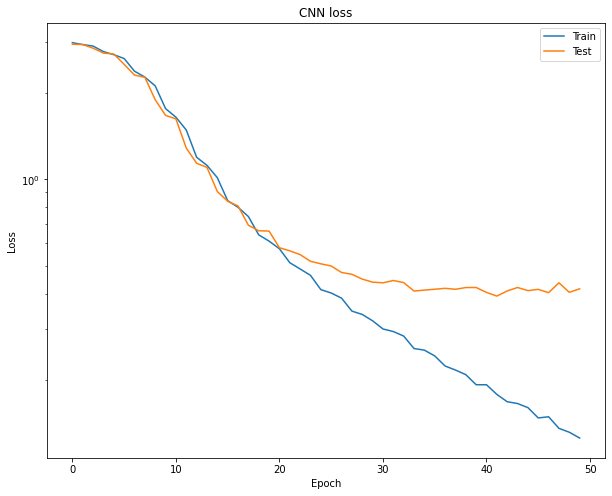

In [8]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['test_loss_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
plt.title('CNN loss')
plt.show()

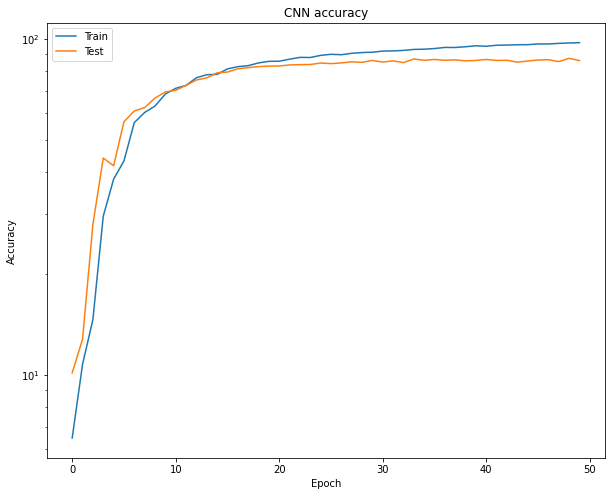

In [9]:
# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['test_acc_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.grid()
plt.legend()
plt.title('CNN accuracy')
plt.show()

In [6]:
from tqdm import tqdm

model_path = "../experiment/k_cross_CNN.pt"

model = torch.load(model_path)

model.to(device)

preds = np.array([])
model.eval()
with torch.no_grad():
    for i, (data, labels) in tqdm(enumerate(test_loader, 0)):
        data, labels = data.to(device), labels.to(device)
        output1 = model(data)
        sm = nn.Softmax(dim=1)(output1)
        pred = sm.max(1, keepdim=True)[1]    
        preds = np.hstack((preds, torch.squeeze(pred).cpu().numpy()))

517it [00:09, 55.71it/s]


In [8]:
f = open("../299_cropped_submission_kfold1.csv", "w")
f.write("Id,Category\n")
for (n,_),p in zip(test_loader.dataset.samples,preds):
    f.write("{},{}\n".format(n.split('/')[-1].split('.')[0], int(p)))
f.close()